# Análise descritiva:



In [ ]:
import scipy.io
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import matplotlib.patches as mpatches
from collections import Counter
import cv2

In [2]:

# --- Configuration ---
BASE_DATA_PATH = "../data" # Make sure this path is correct relative to your script
MAT_FILE_NAME = "mpii_human_pose_v1_u12_1.mat"
IMAGES_FOLDER_NAME = "images" # Ensure your images are in ../data/images/

MAT_FILE_PATH = os.path.join(BASE_DATA_PATH, MAT_FILE_NAME)
IMAGES_FOLDER_PATH = os.path.join(BASE_DATA_PATH, IMAGES_FOLDER_NAME)

# --- Load .mat file ---
try:
    mat_data = scipy.io.loadmat(MAT_FILE_PATH)
    print(f"Successfully loaded: {MAT_FILE_PATH}")
except FileNotFoundError:
    print(f"ERROR: MAT file not found at {MAT_FILE_PATH}")
    exit()
except Exception as e:
    print(f"ERROR: Could not load MAT file: {e}")
    exit()

# --- Extract main data structures ---
try:
    RELEASE = mat_data['RELEASE'][0,0]
    annolist = RELEASE['annolist'][0]
    img_train_flags = RELEASE['img_train'][0]
    activity_data = RELEASE['act'] # This is an array of structs, shape (N, 1)
    print(f"Found {annolist.shape[0]} image entries in annotations.")
except KeyError as e:
    print(f"ERROR: Key not found in MAT file structure: {e}.")
    exit()
except IndexError as e:
    print(f"ERROR: IndexError accessing data in MAT file: {e}.")
    exit()

# --- Parsing Loop ---
parsed_persons_data = []
# Diagnostic counters
images_processed_for_annorect = 0
persons_iterated = 0
persons_with_annopoints = 0
persons_with_point_field = 0
persons_with_valid_joints_array = 0
persons_added_to_list = 0

num_images = annolist.shape[0]
for i in range(num_images):
    image_entry = annolist[i] # This is an np.void (scalar struct for the image)
    is_train_num = img_train_flags[i]

    img_name = None
    try:
        # image_entry['image'] is array([[<struct_with_name>]], dtype=object)
        # image_entry['image'][0,0] is <struct_with_name> (np.void)
        # image_entry['image'][0,0]['name'] is array(['filename.jpg'], dtype='<U...')
        if 'image' in image_entry.dtype.names and \
           isinstance(image_entry['image'], np.ndarray) and image_entry['image'].size > 0 and \
           isinstance(image_entry['image'][0,0], np.void) and \
           'name' in image_entry['image'][0,0].dtype.names and \
           isinstance(image_entry['image'][0,0]['name'], np.ndarray) and \
           image_entry['image'][0,0]['name'].size > 0:
            img_name = image_entry['image'][0,0]['name'][0] # Get the string from the array
        else:
            continue
    except Exception: # Catch any error during image name extraction
        continue

    full_image_path = os.path.join(IMAGES_FOLDER_PATH, img_name)
    if not os.path.exists(full_image_path):
        continue

    activity_name_str = "unknown"
    if i < activity_data.shape[0]:
        current_activity_struct = activity_data[i,0] # This is an np.void (scalar struct)
        if 'act_name' in current_activity_struct.dtype.names:
            # current_activity_struct['act_name'] is an np.ndarray of strings, e.g., array(['some activity'], dtype='<U...')
            # or an empty array, e.g., array([], dtype='<U1')
            act_name_array = current_activity_struct['act_name']
            if isinstance(act_name_array, np.ndarray) and act_name_array.size > 0:
                activity_name = act_name_array[0] # This gets the string from array(['activity_string'])
                if isinstance(activity_name, str) and len(activity_name) > 0:
                    activity_name_str = activity_name

    if 'annorect' not in image_entry.dtype.names or image_entry['annorect'].size == 0:
        continue
    images_processed_for_annorect += 1
    
    person_structs_field = image_entry['annorect'] # This is an ndarray of person structs (np.void)
                                                  # It can be shape (N,) or (1,N).
    
    list_of_person_structs_to_iterate = []
    if person_structs_field.ndim == 1: # Shape (N,)
        list_of_person_structs_to_iterate = person_structs_field
    elif person_structs_field.ndim == 2 and person_structs_field.shape[0] == 1: # Shape (1,N)
        list_of_person_structs_to_iterate = person_structs_field[0] # Get the 1D array
    else:
        continue
        
    if list_of_person_structs_to_iterate.size == 0:
        continue

    # list_of_person_structs_to_iterate is now a 1D array of person structs (np.void)
    for j in range(list_of_person_structs_to_iterate.shape[0]):
        persons_iterated += 1
        person_struct = list_of_person_structs_to_iterate[j] # person_struct is an np.void
        
        if not isinstance(person_struct, np.void):
            continue
            
        if 'annopoints' not in person_struct.dtype.names or person_struct['annopoints'].size == 0:
            continue
        persons_with_annopoints += 1
        
        # person_struct['annopoints'] is typically array([[ <struct_with_point_field> ]], dtype=object)
        annopoints_wrapper = person_struct['annopoints']
        if not (isinstance(annopoints_wrapper, np.ndarray) and \
                annopoints_wrapper.ndim == 2 and annopoints_wrapper.shape == (1,1) and \
                isinstance(annopoints_wrapper[0,0], np.void)):
            continue
        
        struct_containing_point = annopoints_wrapper[0,0] # This is an np.void (scalar struct)

        if 'point' not in struct_containing_point.dtype.names: # Just check for field existence here
            continue
        persons_with_point_field +=1 # Incremented if 'point' field exists
        
        # --- REVISED SECTION FOR 'point' FIELD PARSING ---
        # struct_containing_point['point'] should be a tuple: (ndarray_of_joint_structs,)
        point_field_content = struct_containing_point['point']
            #####
        # Aceita tuple (N,), ndarray (N,), ou ndarray (0,) (vazio)
        if isinstance(point_field_content, tuple):
            # Normalmente é uma tupla de um ndarray
            if len(point_field_content) == 1 and isinstance(point_field_content[0], np.ndarray):
                joints_data_1d_array = point_field_content[0]
            else:
                continue
        elif isinstance(point_field_content, np.ndarray):
            joints_data_1d_array = point_field_content
        else:
            continue

        # Agora, aceita array vazio, mas só processa se não for vazio e for struct
        if not (isinstance(joints_data_1d_array, np.ndarray) and
                joints_data_1d_array.size > 0 and
                joints_data_1d_array.dtype.names is not None and
                all(f_name in joints_data_1d_array.dtype.names for f_name in ['x', 'y', 'id'])):
            continue

            ####
        persons_with_valid_joints_array += 1

        keypoints_dict = {idx: {'x': np.nan, 'y': np.nan, 'visible': np.nan} for idx in range(16)}
        for k in range(joints_data_1d_array.shape[0]): # Iterate over individual joints
            joint_struct = joints_data_1d_array[k]     # joint_struct is an np.void (scalar struct for a joint)
            
            if not isinstance(joint_struct, np.void): 
                continue
            
            # Check if essential fields 'x', 'y', 'id' exist and are not empty arrays
            # Each of these fields (e.g., joint_struct['x']) is an array like array([[value]])
            if not all(f in joint_struct.dtype.names for f in ['x', 'y', 'id']) or \
               not (isinstance(joint_struct['x'], np.ndarray) and joint_struct['x'].size > 0) or \
               not (isinstance(joint_struct['y'], np.ndarray) and joint_struct['y'].size > 0) or \
               not (isinstance(joint_struct['id'], np.ndarray) and joint_struct['id'].size > 0):
                continue
            try:
                # Values are typically wrapped in (1,1) arrays
                joint_x = joint_struct['x'][0,0]
                joint_y = joint_struct['y'][0,0]
                joint_id = joint_struct['id'][0,0]
            except IndexError: # If not (1,1) array or empty after all
                continue
            
            is_visible_val = np.nan
            if 'is_visible' in joint_struct.dtype.names:
                vis_field = joint_struct['is_visible'] # This is an ndarray, e.g. array([[1]]) or array([])
                if isinstance(vis_field, np.ndarray) and vis_field.size > 0:
                    try:
                        val_to_convert = None
                        # Handle various ways scalar might be stored in vis_field
                        if vis_field.ndim == 2 and vis_field.shape == (1,1): # e.g. array([[1]])
                             val_to_convert = vis_field[0,0]
                        elif vis_field.ndim == 1 and vis_field.shape == (1,): # e.g. array([1])
                             val_to_convert = vis_field[0]
                        elif vis_field.ndim == 0: # e.g. array(1) (scalar array)
                             val_to_convert = vis_field.item()
                        
                        if val_to_convert is not None:
                            # Ensure val_to_convert is not an empty array itself if somehow passed through
                            if not (isinstance(val_to_convert, np.ndarray) and val_to_convert.size == 0):
                                is_visible_val = int(val_to_convert)
                    except (ValueError, TypeError):
                        pass # Keep NaN if conversion fails or type is unexpected
            
            if 0 <= joint_id < 16: # MPII has 16 joints, IDs 0-15
                 keypoints_dict[int(joint_id)] = {'x': float(joint_x), 'y': float(joint_y), 'visible': is_visible_val}

        persons_added_to_list +=1
        parsed_persons_data.append({
            'image_path': full_image_path,
            'image_name': img_name,
            'is_train': bool(is_train_num),
            'activity_name': activity_name_str,
            'person_index_in_image': j,
            'keypoints': keypoints_dict
        })

# --- Print diagnostic counters ---
print(f"\n--- Diagnostics ---")
print(f"Total image entries in annolist: {num_images}")
print(f"Images processed (had 'annorect' and img_file existed): {images_processed_for_annorect}")
print(f"Total person instances iterated over: {persons_iterated}")
print(f"Persons found with 'annopoints' field: {persons_with_annopoints}")
print(f"Persons found with 'point' field in annopoints: {persons_with_point_field}")
print(f"Persons with a valid 'joints_data_array': {persons_with_valid_joints_array}")
print(f"Total persons successfully parsed and added: {persons_added_to_list}")


# --- Convert to Pandas DataFrame ---
df_persons = pd.DataFrame(parsed_persons_data)
print(f"\nSuccessfully parsed {len(df_persons)} person instances into DataFrame.")
if not df_persons.empty:
    print("\nFirst 5 rows of the parsed data:")
    print(df_persons.head())
    if len(df_persons) > 0 and 'keypoints' in df_persons.columns:
        print(f"\nSample keypoints for the first parsed person: {df_persons.iloc[0]['keypoints']}")
else:
    print("\nNo person instances were successfully parsed into DataFrame. Check diagnostic counters and .mat structure.")

Successfully loaded: ../data/mpii_human_pose_v1_u12_1.mat
Found 24987 image entries in annotations.

--- Diagnostics ---
Total image entries in annolist: 24987
Images processed (had 'annorect' and img_file existed): 24167
Total person instances iterated over: 40939
Persons found with 'annopoints' field: 28883
Persons found with 'point' field in annopoints: 28883
Persons with a valid 'joints_data_array': 28883
Total persons successfully parsed and added: 28883

Successfully parsed 28883 person instances into DataFrame.

First 5 rows of the parsed data:
                     image_path     image_name  is_train activity_name  \
0  ../data/images/015601864.jpg  015601864.jpg      True       curling   
1  ../data/images/015601864.jpg  015601864.jpg      True       curling   
2  ../data/images/015599452.jpg  015599452.jpg      True       curling   
3  ../data/images/015599452.jpg  015599452.jpg      True       curling   
4  ../data/images/015599452.jpg  015599452.jpg      True       curling  

In [ ]:
# as atividades com mais imagens
df_persons["activity_name"].value_counts()[:20]

activity_name
ballet, modern, or jazz                              565
aerobic, step                                        416
ballroom                                             413
aerobic, general                                     349
yoga, Power                                          336
paddleball                                           334
softball, general                                    330
bicycling, racing and road                           325
soccer                                               307
video exercise workouts, TV conditioning programs    301
standing, miscellaneous                              299
martial arts, different types                        294
bicycling, mountain                                  285
standing quietly, standing in a line                 278
basketball                                           273
cooking or food preparation                          267
rowing, stationary                                   265
standing, talking

In [ ]:
# dataset final
df_persons

,image_path,image_name,is_train,activity_name,person_index_in_image,keypoints
0,../data/images/015601864.jpg,015601864.jpg,True,curling,0,"{0: {'x': nan, 'y': nan, 'visible': nan}, 1: {..."
1,../data/images/015601864.jpg,015601864.jpg,True,curling,1,"{0: {'x': nan, 'y': nan, 'visible': nan}, 1: {..."
2,../data/images/015599452.jpg,015599452.jpg,True,curling,0,"{0: {'x': nan, 'y': nan, 'visible': nan}, 1: {..."
3,../data/images/015599452.jpg,015599452.jpg,True,curling,1,"{0: {'x': nan, 'y': nan, 'visible': nan}, 1: {..."
4,../data/images/015599452.jpg,015599452.jpg,True,curling,2,"{0: {'x': nan, 'y': nan, 'visible': nan}, 1: {..."
...,...,...,...,...,...,...
28878,../data/images/084761779.jpg,084761779.jpg,True,pushing car,0,"{0: {'x': nan, 'y': nan, 'visible': nan}, 1: {..."
28879,../data/images/084761779.jpg,084761779.jpg,True,pushing car,1,"{0: {'x': nan, 'y': nan, 'visible': nan}, 1: {..."
28880,../data/images/084761779.jpg,084761779.jpg,True,pushing car,2,"{0: {'x': nan, 'y': nan, 'visible': nan}, 1: {..."
28881,../data/images/084761779.jpg,084761779.jpg,True,pushing car,3,"{0: {'x': nan, 'y': nan, 'visible': nan}, 1: {..."


In [ ]:
# lista de atividades unicas
df_persons["activity_name"].unique()

array([np.str_('curling'), np.str_('sitting quietly'),
       np.str_('sitting, talking in person, on the phone, computer, or text messaging, light effort'),
       np.str_('truck driving, loading and unloading truck, tying down load, standing, walking and carrying heavy lo'),
       np.str_('swimming, synchronized'), np.str_('scrubbing floors'),
       np.str_('mopping, standing, light effort'),
       np.str_('chambermaid, hotel housekeeper, making bed, cleaning bathroom, pushing cart'),
       np.str_('cleaning, general'),
       np.str_('implied walkingstanding - picking up yard, light, picking flowers or vegetables'),
       np.str_('gardening, general, moderate effort'),
       np.str_('standing, talking in person'),
       np.str_('standing, miscellaneous'),
       np.str_('lawn bowling, bocce ball, outdoor'),
       np.str_('serving food in church'), np.str_('skiing, downhill'),
       np.str_('skiing, cross-country'), np.str_('skiing, climbing up'),
       np.str_('horse groom

Distribuição das classes:
 new_class
walking     143
standing    110
sitting     106
Name: count, dtype: int64

Proporção de cada classe (%):
 new_class
walking     39.83
standing    30.64
sitting     29.53
Name: count, dtype: float64


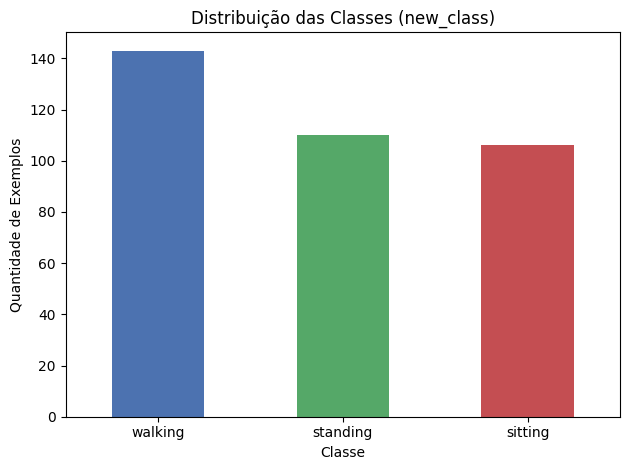

In [ ]:
# teste manual para verificar desbalanceamento entre classes


poses = ["sitting, talking in person, on the phone, computer, or text messaging, light effort",'sitting quietly','walking, for exerceise, with ski poles','paddle boarding, standing','standing, doing work','skating, ice dancing']
df_test = df_persons[df_persons["activity_name"].isin(poses)]
df_test = df_test.drop_duplicates(subset=["image_name"])

df_test["new_class"] = df_test["activity_name"].map({
    "standing, doing work": "standing",
    "paddle boarding, standing": "standing",
    "sitting quietly": "sitting",
    "sitting, talking in person, on the phone, computer, or text messaging, light effort": "sitting",
    "walking, for exerceise, with ski poles": "walking",
    "skating, ice dancing": "walking"
})

# Análise do desbalanceamento entre classes
vc = df_test["new_class"].value_counts()
print("Distribuição das classes:\n", vc)
print("\nProporção de cada classe (%):\n", (vc / vc.sum() * 100).round(2))

# Visualização
vc.plot(kind="bar", color=["#4C72B0", "#55A868", "#C44E52"])
plt.title("Distribuição das Classes (new_class)")
plt.xlabel("Classe")
plt.ylabel("Quantidade de Exemplos")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

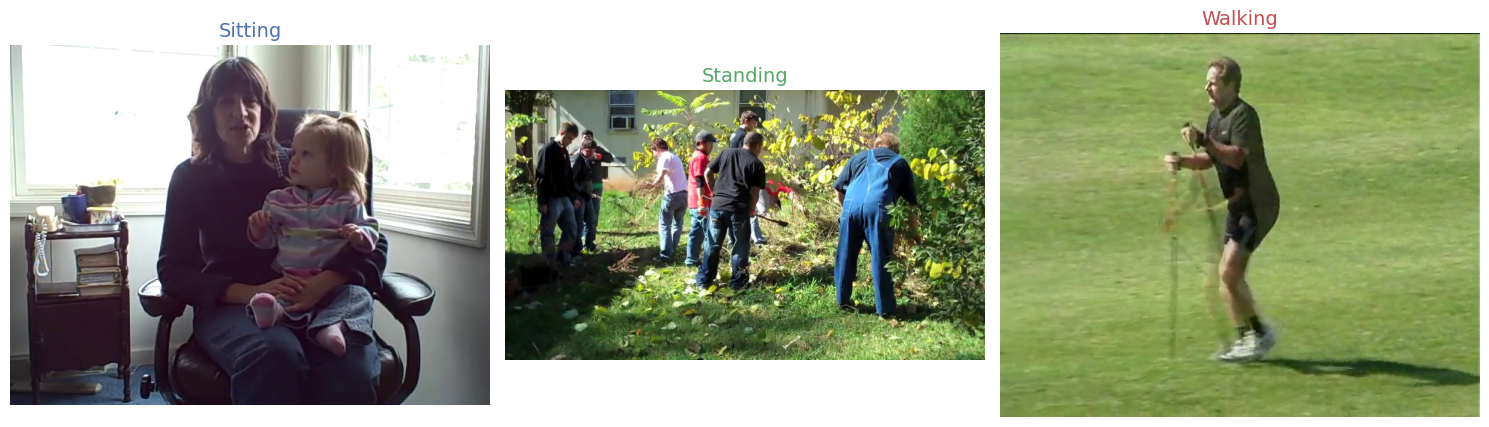

In [ ]:
#visualização das poses

# Define cores para cada classe
class_colors = {
    "sitting": "#4C72B0",
    "standing": "#55A868",
    "walking": "#C44E52"
}

# Lista de conexões de pares de juntas (exemplo para MPII, pode ajustar conforme necessário)
skeleton_pairs = [
    (0, 1), (1, 2), (2, 6), (6, 3), (3, 4), (4, 5), # tronco e cabeça
    (6, 7), (7, 8), (8, 9), # braço direito
    (6, 12), (12, 13), (13, 14), # perna direita
    (6, 11), (11, 10), (10, 15)  # perna esquerda
]

# Função para plotar uma pessoa com keypoints
def plot_pose(image_path, keypoints, ax, color):
    img = cv2.imread(image_path)
    if img is None:
        ax.set_title("Imagem não encontrada")
        ax.axis('off')
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img)
    # Plot keypoints
    for idx, kp in keypoints.items():
        if not np.isnan(kp['x']) and not np.isnan(kp['y']):
            ax.scatter(kp['x'], kp['y'], c=color, s=30, edgecolors='k')
    # Plot skeleton
    for a, b in skeleton_pairs:
        if all(idx in keypoints for idx in [a, b]):
            kp_a, kp_b = keypoints[a], keypoints[b]
            if not (np.isnan(kp_a['x']) or np.isnan(kp_a['y']) or np.isnan(kp_b['x']) or np.isnan(kp_b['y'])):
                ax.plot([kp_a['x'], kp_b['x']], [kp_a['y'], kp_b['y']], c=color, linewidth=2)
    ax.axis('off')

# Exemplo de uma imagem por classe
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (classe, color) in enumerate(class_colors.items()):
    row = df_test[df_test["new_class"] == classe].iloc[0]
    plot_pose(row["image_path"], row["keypoints"], axs[i], color)
    axs[i].set_title(classe.capitalize(), color=color, fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:


# Análise das características das imagens do subconjunto df_test


# Coletar resoluções das imagens
resolucoes = []
ruidos = []
poses_por_imagem = []

for idx, row in df_test.iterrows():
    img = cv2.imread(row["image_path"])
    if img is not None:
        h, w = img.shape[:2]
        resolucoes.append((w, h))
        # Simples detecção de ruído: desvio padrão dos pixels (quanto maior, mais ruído/variação)
        stddev = img.std()
        ruidos.append(stddev)
        # Variação de pose: contar quantos keypoints válidos (não-nan) existem
        keypoints = row["keypoints"]
        n_valid = sum(
            1 for kp in keypoints.values()
            if not (np.isnan(kp['x']) or np.isnan(kp['y']))
        )
        poses_por_imagem.append(n_valid)
    else:
        # Imagem não encontrada, ignorar
        continue


# Estatísticas de ruído
if ruidos:
    print("Desvio padrão médio dos pixels (indicador de ruído): {:.2f}".format(np.mean(ruidos)))
    print("Desvio padrão mínimo/máximo: {:.2f} / {:.2f}".format(np.min(ruidos), np.max(ruidos)))
else:
    print("Não foi possível calcular ruído (imagens não encontradas).")


Desvio padrão médio dos pixels (indicador de ruído): 60.04
Desvio padrão mínimo/máximo: 29.57 / 106.06
